In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

# データの準備

 - [Binance Data - BTC/USD\[Minute\]](https://www.cryptodatadownload.com/cdd/Binance_BTCUSDT_minute.csv)

In [190]:
dataset = pd.read_csv('data/Binance_BTCUSDT_minute.csv', skiprows=1, index_col=1, parse_dates=True).sort_index()

feature_df = pd.DataFrame({
    '収益率': dataset['close'].pct_change(),
    'BTCの取引量': dataset['Volume BTC'],
    'USDTの取引量': dataset['Volume USDT'],
    '取引回数': dataset['tradecount'],
    '差分': dataset['open'] - dataset['close']
})

teacher_ser = dataset['close'].pct_change().shift(-1)
teacher_ser = (teacher_ser)
teacher_ser = teacher_ser.rename('teacher')

In [191]:
merged = pd.merge(teacher_ser, feature_df, left_index=True, right_index=True, how='inner').dropna()
teacher_ser = merged.pop('teacher')
feature_df = merged

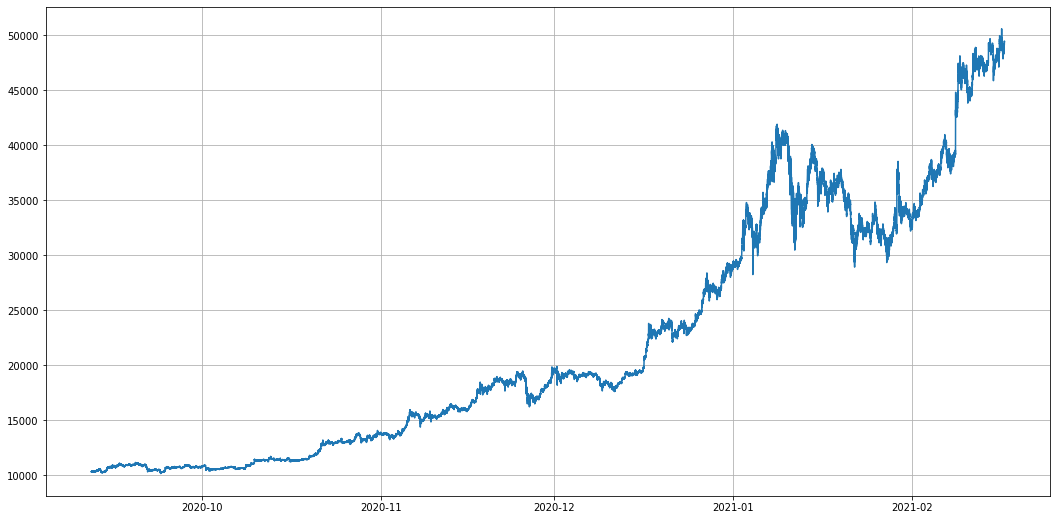

In [192]:
plt.figure(figsize=(18, 9))
plt.plot(dataset['close'])
plt.grid(True)
plt.show()

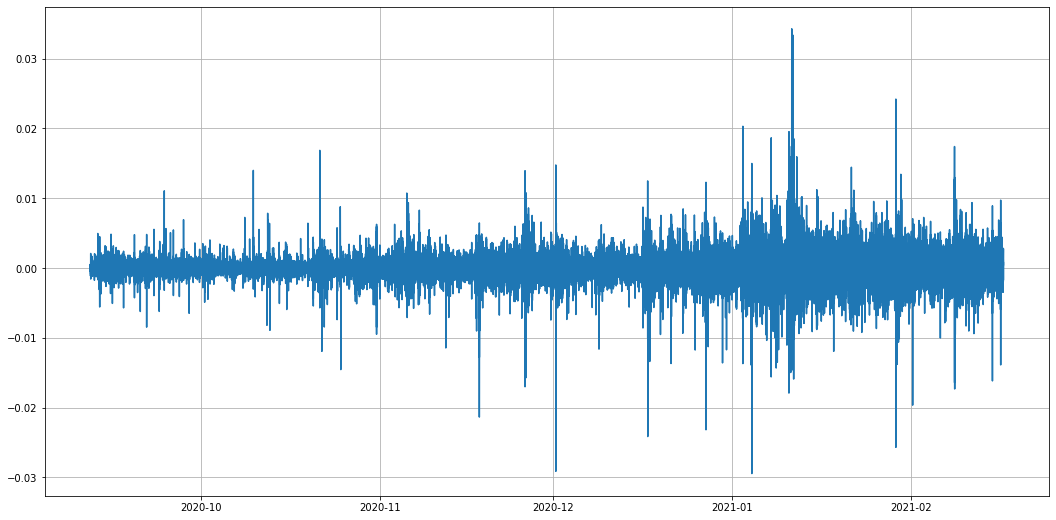

In [193]:
plt.figure(figsize=(18, 9))
plt.plot(teacher_ser)
plt.grid(True)
plt.show()

In [194]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_df, teacher_ser, test_size=0.3, shuffle=False)

In [195]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# モデルの構築

 - [Recurrentレイヤー#SimpleRNN - Keras Documentation](https://keras.io/ja/layers/recurrent/#simplernn)
 - [活性化関数 - Keras Documentation](https://keras.io/ja/activations/)
 - [レイヤーの重み初期化 - Keras Documentation](https://keras.io/ja/initializers/)

In [196]:
import tensorflow as tf


特徴量の数 = len(X_train.keys())

# About Simple RNN
系列長の長さ = 10
出力の次元数 = 5

シンプルRNN = tf.keras.Sequential([
    tf.keras.layers.InputLayer(batch_input_shape=(None, 系列長の長さ, 特徴量の数), name='input_layer'),
    tf.keras.layers.SimpleRNN(units=出力の次元数, activation='linear', use_bias=True, name='internal_layer'),
    tf.keras.layers.Dense(1, activation="linear", name="output_layer")
], name='SimpleRNN')

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [ ]:
シンプルRNN.summary()

# 学習プロセスの設定

 - [最適化 - Keras Documentation](https://keras.io/ja/optimizers/)
 - [損失関数 - Keras Documentation](https://keras.io/ja/losses/)
 - [評価関数 - Keras Documentation](https://keras.io/ja/metrics/)

In [ ]:
最適化アルゴリズム = 'adam'
損失関数 = 'mse'
評価関数_list  = ['mse']

シンプルRNN.compile(
    optimizer=最適化アルゴリズム,
    loss=損失関数,
    metrics=評価関数_list
)

# 学習

In [197]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


バッチサイズ = 1000
エポック数 = 5000
# コールバックs = []
コールバックs = [EarlyStopping(monitor='val_loss', patience=10)]  # 最低10エポックはパラメーターを更新する

generator = TimeseriesGenerator(X_train, y_train, length=系列長の長さ, batch_size=バッチサイズ)
X, y = generator[0]

history = シンプルRNN.fit(
    X, y, 
    validation_split=0.2,
    batch_size=バッチサイズ,
    epochs=エポック数,
    callbacks=コールバックs
)

Epoch 1/5000
1/1 [==============================] - 0s 78ms/step - loss: 9.0376e-07 - mse: 9.0376e-07 - val_loss: 1.1811e-06 - val_mse: 1.1811e-06
Epoch 2/5000
1/1 [==============================] - 0s 81ms/step - loss: 1.0273e-06 - mse: 1.0273e-06 - val_loss: 7.9306e-07 - val_mse: 7.9306e-07
Epoch 3/5000
1/1 [==============================] - 0s 105ms/step - loss: 1.0370e-06 - mse: 1.0370e-06 - val_loss: 1.0321e-06 - val_mse: 1.0321e-06
Epoch 4/5000
1/1 [==============================] - 0s 75ms/step - loss: 8.9700e-07 - mse: 8.9700e-07 - val_loss: 4.5464e-07 - val_mse: 4.5464e-07
Epoch 5/5000
1/1 [==============================] - 0s 116ms/step - loss: 6.3428e-07 - mse: 6.3428e-07 - val_loss: 4.1835e-07 - val_mse: 4.1835e-07
Epoch 6/5000
1/1 [==============================] - 0s 83ms/step - loss: 3.9193e-07 - mse: 3.9193e-07 - val_loss: 2.4911e-07 - val_mse: 2.4911e-07
Epoch 7/5000
1/1 [==============================] - 0s 116ms/step - loss: 2.9622e-07 - mse: 2.9622e-07 - val_loss: 2

In [198]:
学習推移_df = pd.DataFrame(history.history, index=history.epoch)
学習推移_df.head()

,loss,mse,val_loss,val_mse
0,9.037647e-07,9.037647e-07,1.181144e-06,1.181144e-06
1,1.027254e-06,1.027254e-06,7.930587e-07,7.930587e-07
2,1.036967e-06,1.036967e-06,1.032088e-06,1.032088e-06
3,8.969986e-07,8.969986e-07,4.546413e-07,4.546413e-07
4,6.342754e-07,6.342754e-07,4.183473e-07,4.183473e-07


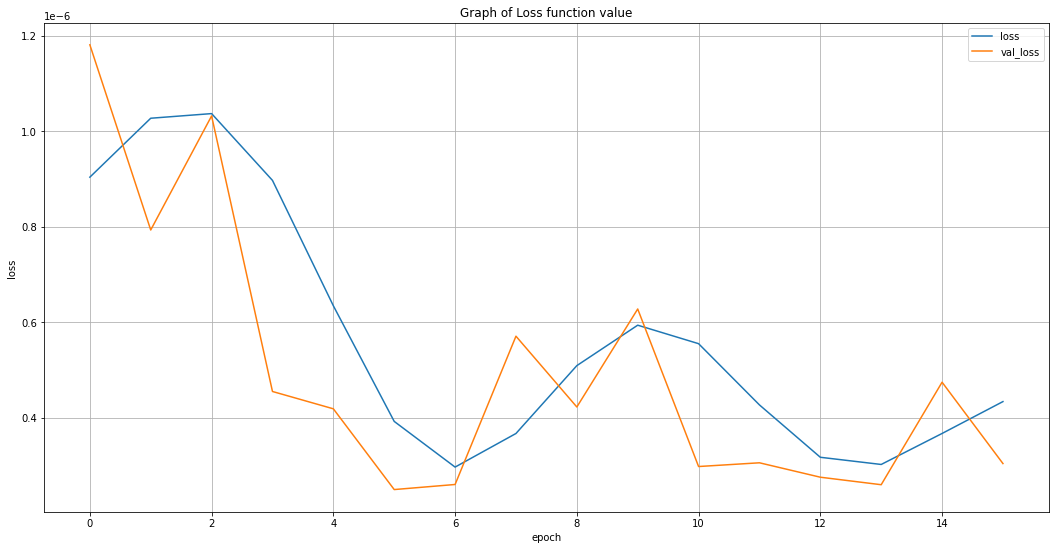

In [199]:
import matplotlib.pyplot as plt


plt.figure(figsize=(18, 9))
plt.title("Graph of Loss function value")
plt.plot(学習推移_df['loss'], label='loss')
plt.plot(学習推移_df['val_loss'], label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# 評価

In [200]:
X, y = TimeseriesGenerator(X_test, y_test.values, length=系列長の長さ, batch_size=10000)[0]

In [201]:
pd.Series(
    シンプルRNN.evaluate(X, y),
    index=シンプルRNN.metrics_names,
    name='評価指標'
)

313/313 [==============================] - 1s 5ms/step - loss: 4.5793e-04 - mse: 4.5793e-04


loss    0.000458
mse     0.000458
Name: 評価指標, dtype: float64

# 予測

In [202]:
シンプルRNN.predict(X_test[-系列長の長さ:].reshape(-1, 系列長の長さ, 特徴量の数))

array([[-0.00994595]], dtype=float32)

In [203]:
y_test.tail()

date
2021-02-17 00:01:00    0.001612
2021-02-17 00:02:00   -0.000568
2021-02-17 00:03:00    0.001924
2021-02-17 00:04:00   -0.001657
2021-02-17 00:05:00    0.000776
Name: teacher, dtype: float64

In [204]:
y_pred = シンプルRNN.predict(X.reshape(-1, 系列長の長さ, 特徴量の数))

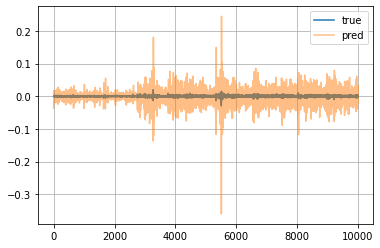

In [205]:
plt.plot(y, label='true')
plt.plot(y_pred, label='pred', alpha=0.5)
plt.grid()
plt.legend()
plt.show()

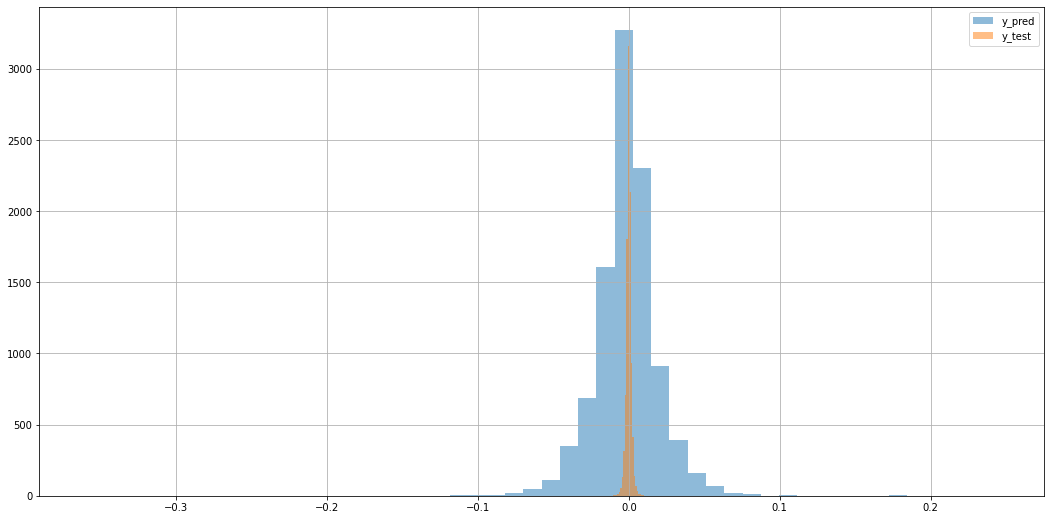

In [207]:
plt.figure(figsize=(18, 9))
plt.hist(y_pred, bins=50, label='y_pred', alpha=0.5)
plt.hist(y, bins=50, label='y_test', alpha=0.5)
plt.grid()
plt.legend()
plt.show()